In [1]:
import numpy as np
import scipy as sp
import matplotlib as mp
from matplotlib import pyplot as plt
import skimage as ski
from scipy.fft import fft, fftfreq, ifft, rfft, fftshift
import scipy.signal.windows as wind
from matplotlib.widgets import SpanSelector, Button
import os

ModuleNotFoundError: No module named 'skimage'

1) Сделать краткий отчет
2) Уточнить значение сигналов
3) Попытаться убрать шумы, чтобы получилось как раньше

Дедлайн чт

In [5]:
path, file = "C:/Users/User/Pictures/Aspa", input("Введите имя файла с указанием формата: ")
filename = os.path.join(path, file)
signal = ski.io.imread(filename)

In [6]:
pixcolor = []
rgb = ["r", "g", "b"]
print("Введите цвет линии в формате rgb \n")
for j in range(3):
    pixcolor.append(int(input(rgb[j]+" : ")))

Введите цвет линии в формате rgb 



## Создаем массив масок по каждому столбцу пикселей

Сканируем изображение в следующем порядке: сверху вниз, слева направо, начиная с верхнего левого пикселя. 
В результате для каждого вертикального столбца пикселей получим "маску" - массив булевских значений, каждое из значений которого соответствует одному пикселю начинае сверху. Если цвет равен целевому - ставется true, иначе false.

In [7]:
masks = np.array([[0 for j in range(signal.shape[1])] for i in range(signal.shape[0])], dtype = 'bool')
for j in range(signal.shape[1]):
    for i in range(signal.shape[0]):
        masks[i][j] = (signal[i][j][0] == pixcolor[0] and signal[i][j][1] == pixcolor[1] and signal[i][j][2] == pixcolor[2])

## Переводим маски в числа

Для каждой маски находим координаты всех истинных значений. Если значений больше одного - берём среднее арифметическое.
Все nan заменяем на 0.

In [8]:
rows = np.arange(signal.shape[0])
sig_dig = np.zeros(signal.shape[1])
for j in range(signal.shape[1]):
    mask = masks[:,j]
    sig_dig[j] = (signal.shape[0] - np.ceil(np.mean(rows[mask])) - np.floor(signal.shape[0] / 2)) / (signal.shape[0]) * 2
sig_dig[np.isnan(sig_dig)] = 0

c:\Users\User\miniforge3\envs\skimage-env\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\miniforge3\envs\skimage-env\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [11]:
# A copy is useful if you later want "Reset" functionality
original_signal = sig_dig.copy()

# -------------------------------
# Undo stack (list of previous signal states)
# -------------------------------
undo_stack = []

In [12]:
# -------------------------------
# Selection handler
# -------------------------------
def onselect(xmin, xmax):
    global signal, undo_stack

    i_min = int(max(0, np.floor(xmin)))
    i_max = int(min(len(signal), np.ceil(xmax)))

    # Save previous state for undo
    undo_stack.append(signal.copy())

    print(f"Selected interval: {i_min} → {i_max}")

    # Zero out selected region
    signal[i_min:i_max] = 0

    # Update plot
    line.set_ydata(signal)
    fig.canvas.draw_idle()

In [17]:
# -------------------------------
# Undo handler
# -------------------------------
def undo(event):
    global signal, undo_stack

    if not undo_stack:
        print("Undo stack empty.")
        return

    # Restore previous state
    signal = undo_stack.pop()

    print("Undo: restored previous signal state")

    # Update plot
    line.set_ydata(signal)
    fig.canvas.draw_idle()

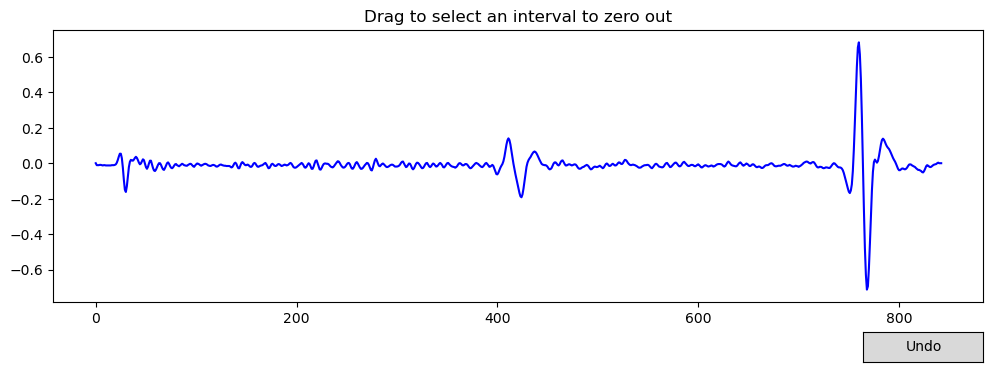

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.subplots_adjust(bottom=0.2)  # leave room for buttons
# -------------------------------
# Add Undo button
# -------------------------------
undo_ax = fig.add_axes([0.8, 0.05, 0.1, 0.075])
undo_button = Button(undo_ax, "Undo")
undo_button.on_clicked(undo)

# -------------------------------
# Enable drag selection
# -------------------------------
span = SpanSelector(
    ax,
    onselect,
    direction='horizontal',
    useblit=True,
    props=dict(alpha=0.3, facecolor='red'),
    interactive=True
)


line, = ax.plot(sig_dig, color='blue')
ax.set_title("Drag to select an interval to zero out")
plt.show()

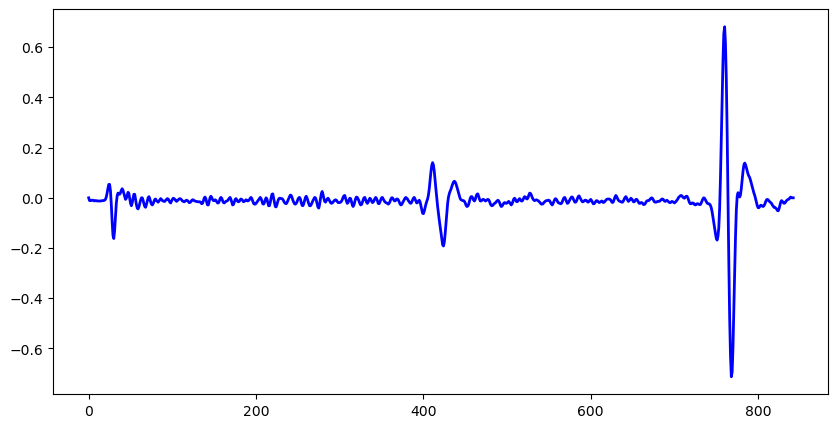

In [10]:
plt.figure(figsize = (10, 5))
plt.plot(sig_dig, color = 'b', linewidth = 2)
#ax = plt.gca() 
#ax.set_xticks(np.arange(0, signal.size, 50))
#ax.set_facecolor("grey")
plt.show()

## Обнуляем сигнал

In [ ]:
N = signal.shape[0]


In [ ]:
zero_mask = np.abs(sig_dig) <= 0.09 * np.max(sig_dig)
zero_mask[450:1000] = False
zero_mask[1000:] = True
sig_dig[zero_mask] = 0

In [ ]:
zero_mask

In [19]:
sig_dig.size

843

In [3]:
plt.figure(figsize = (17, 4))
plt.plot(sig_dig, color = 'b', linewidth = 2)
ax = plt.gca() 
#ax.set_xticks(np.arange(0, signal.size, 50))
#ax.set_facecolor("grey")
plt.show()

NameError: name 'sig_dig' is not defined

<Figure size 1700x400 with 0 Axes>

In [28]:
N = signal[685:].shape[1]
matrix = np.array([[0 for k in range(N)] for i in range(5)], dtype = 'float64')
t_matrix = np.array([[0 for k in range(N)] for i in range(5)], dtype = 'float64')

In [29]:
x_min = 41.65
x_max = 50.8
delta_x = x_max - x_min
c = 1.8e-6
t_max = delta_x * c
t = np.linspace(- t_max / 2, t_max / 2, N)
delta_t = np.abs(t[1] - t[0])

In [30]:
line_c = 899 #Координата линии отсечки
signal2 = sig_dig[685:] 
#spectrum = fft_manual2(signal2)
spectrum = fftshift(fft(fftshift(signal2))) / N - 0.00024
spect_f = fftfreq(N, delta_t) * 2 * np.pi

matrix[0,:] = signal2
t_matrix[0,:] = t
matrix[1,:] = np.abs(spectrum)
t_matrix[1,:] = fftshift(spect_f)
#matrix[2,:] = np.angle(spectrum)

matrix[3,:] = np.real(spectrum)
matrix[3, line_c:] = 0.00001
t_matrix[3,:] = fftshift(spect_f)
matrix[4,:] = np.imag(spectrum)
t_matrix[4,:] = fftshift(spect_f)
matrix[4, line_c:] = 0

matrix[2,:] = np.arctan(matrix[4,:] / matrix[3,:])
t_matrix[2,:] = fftshift(spect_f)

ValueError: could not broadcast input array from shape (158,) into shape (843,)

In [16]:
N / 16

52.6875

IndexError: index 899 is out of bounds for axis 1 with size 843

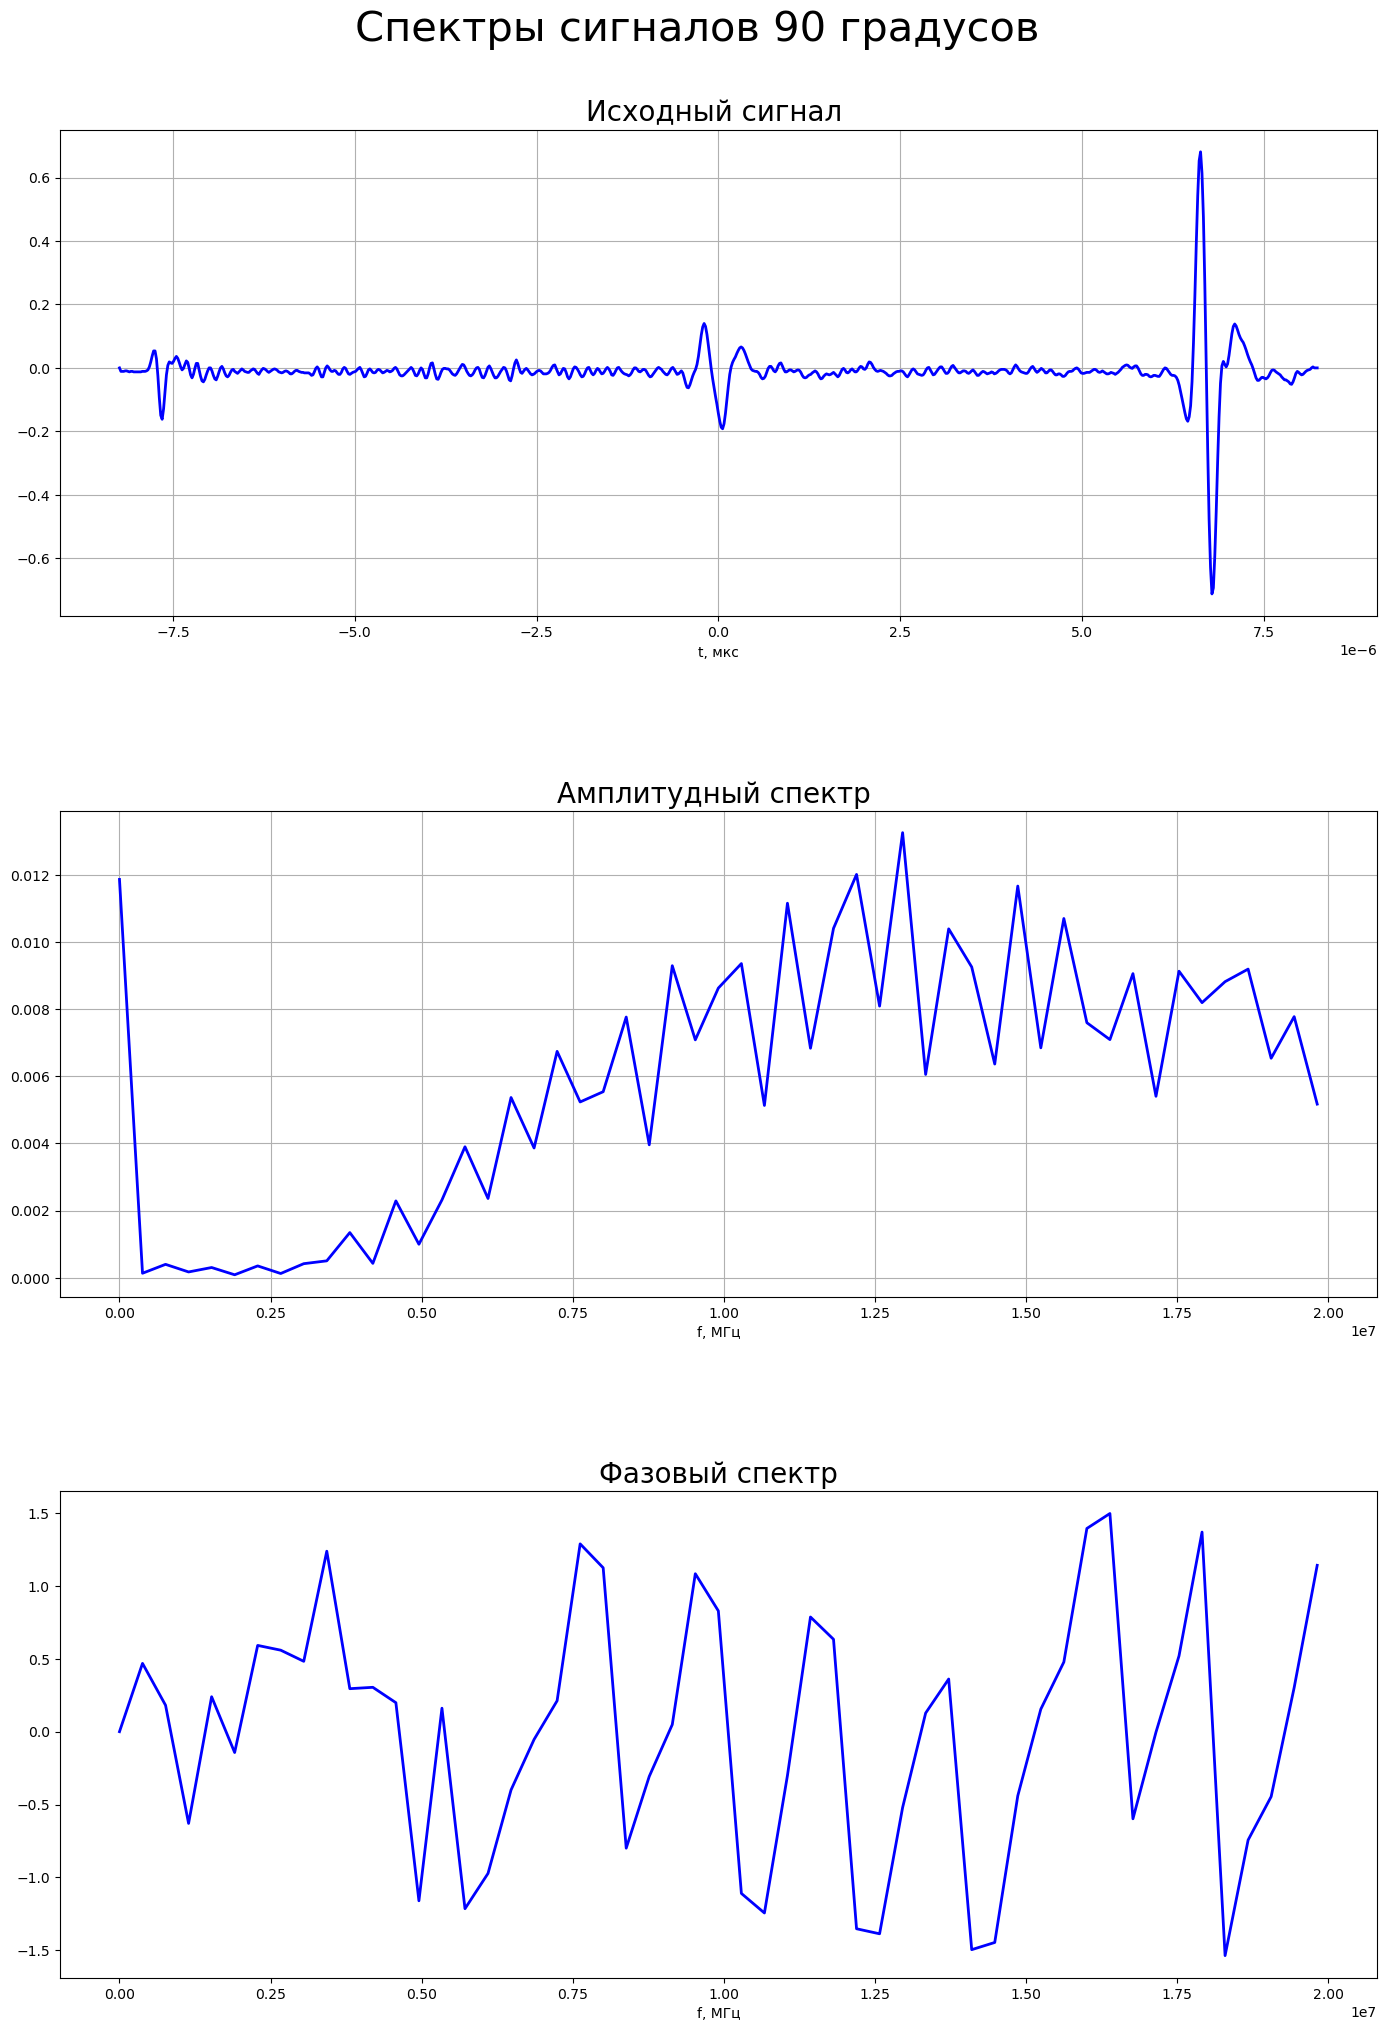

In [17]:
fig, axs = plt.subplots(3, 1, figsize = (17, 24))

fig.suptitle("Спектры сигналов 90 градусов", y = 0.93, fontsize = 30)
plt.subplots_adjust(hspace=0.4)
Na = N / 16 #Размер окна для спектра

axs[0].plot(t_matrix[0,:], matrix[0,:], color = 'b', linewidth = 2)
axs[0].set_title("Исходный сигнал ", fontsize = 20)
#axs[0].set_xticks(np.arange(min(t), max(t), 5))
axs[0].set_xlabel("t, мкс", loc = 'center')
#axs[0].set_ylim(-1.0, 1.0)
#axs[0].set_facecolor("black")
axs[0].grid('on')

axs[1].plot(t_matrix[1,int(N /2) : int(N /2 + Na)], matrix[1,int(N /2) : int(N /2 + Na)], color = 'b', linewidth = 2)
axs[1].set_title("Амплитудный спектр ", fontsize = 20)
axs[1].set_xlabel("f, МГц", loc = 'center')
#axs[1].set_facecolor("black")
#axs[1].axvline(t_matrix[1,line_c], color = 'red')
axs[1].grid('on')

axs[2].plot(t_matrix[2,int(N /2) : int(N /2 + Na)], matrix[2,int(N /2) : int(N /2 + Na)], color = 'b', linewidth = 2)
axs[2].set_title("Фазовый спектр", fontsize = 20)
axs[2].set_xlabel("f, МГц", loc = 'center')
#axs[2].set_facecolor("black")
axs[2].axvline(t_matrix[2,line_c], color = 'red')
axs[2].grid('on')

#axs[3].plot(t_matrix[3,int(N /2) : int(N /2 + Na)], matrix[3,int(N /2) : int(N /2 + Na)], color = 'y', linewidth = 2)
#axs[3].set_title("Действит. часть ", fontsize = 20)
#axs[3].set_xlabel("f, МГц", loc = 'center')
#axs[3].set_facecolor("black")
#axs[3].axvline(t_matrix[3,line_c], color = 'red')
#axs[3].grid('on')

#axs[4].plot(t_matrix[4,int(N /2) : int(N /2 + Na)], matrix[4,int(N /2) : int(N /2 + Na)], color = 'y', linewidth = 2)
#axs[4].set_title("Мним. часть", fontsize = 20)
#axs[4].set_xlabel("f, МГц", loc = 'center')
#axs[4].set_facecolor("black")
#axs[4].axvline(t_matrix[4,line_c], color = 'red')
#axs[4].grid('on')

In [ ]:
t

In [ ]:
plt.plot(matrix[3,800:900])

lorem ipsum